In [ ]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import xarray as xr
import cartopy.crs as ccrs
from pyresample.geometry import AreaDefinition
from pyresample.geometry import GridDefinition
from pyresample import image, geometry, load_area, save_quicklook, SwathDefinition, area_def2basemap
from pyresample.kd_tree import resample_nearest
from scipy import spatial
sys.path.append('../saildrone/subroutines/')
from read_routines import read_all_usv, read_one_usv, add_coll_vars,get_filelist_l2p,get_orbital_data_l2p
import warnings
warnings.simplefilter('ignore') # filter some warning messages
from glob import glob

# Read in All Saildrone cruises downloaded from https://data.saildrone.com/data/sets
- 2017 onwards, note that earlier data is going to lack insruments and be poorer data quality in general
- For this code I want to develop a routine that reads in all the different datasets and creates a standardized set
- It may work best to first read each of the files individually into a dictionary 
- then go through each dataset finding all variable names
- I decided to put all SST into TEMP_CTD_MEAN and same for Salinity so there is a single variable name
- this still preserves all the dataset information

In [ ]:
dir_data = 'C:/Users/gentemann/Google Drive/public/2019_saildrone/' #'f:/data/cruise_data/saildrone/saildrone_data/'
dir_data_pattern = 'C:/Users/gentemann/Google Drive/public/2019_saildrone/*.nc' 

dir_out = 'F:/data/cruise_data/saildrone/sss/sss_collocations_8day/'
dir_out2 = 'F:/data/cruise_data/saildrone/sss/sss_collocations_8day_nearest/'

data_dict = read_all_usv(dir_data_pattern)
data_dict = add_coll_vars(data_dict)


# Check on lat/lon range, names, etc.

In [ ]:
#RSS test open
#file = 'F:/data/sat_data/smap/SSS/L3/RSS/V4/8day_running/SCI/2016/001/RSS_smap_SSS_L3_8day_running_2016_005_FNL_v04.0.nc'
#ds = xr.open_dataset(file)
#ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
#ds = ds.sortby(ds.lon)
#ds.close()  


# Collocate SMAP RSS 8day

In [ ]:
#RSS
#get list of all filenames in directory
adir = 'F:/data/sat_data/smap/SSS/L3/RSS/V4/8day_running/SCI/**/**/*.nc'
files = [x for x in glob(adir)]
print('number of file:',len(files))

ds = xr.open_mfdataset(files,combine='nested',concat_dim='time')
ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
ds = ds.sortby(ds.lon)
ds.close()  


# Collocate using .interp linear interpolation

In [ ]:
%%time
for iname,name in enumerate(data_dict):
    print(iname)
    ds_usv = data_dict[name]
    ds_usv['lat'] = ds_usv.lat.interpolate_na(dim='time',method='linear').ffill(dim='time').bfill(dim='time')
    ds_usv['lon'] = ds_usv.lon.interpolate_na(dim='time',method='linear').ffill(dim='time').bfill(dim='time')
    tem = ds_usv.lat.ffill(dim='time')
    tem = ds_usv.lat.bfill(dim='time')
    t1,t2=ds_usv.time.min().data-np.timedelta64(8,'D'),ds_usv.time.max().data+np.timedelta64(8,'D')
    x1,x2=ds_usv.lon.min().data,ds_usv.lon.max().data
    y1,y2=ds_usv.lat.min().data,ds_usv.lat.max().data
    print(t1,t2)
    ds_sat = ds.sel(time=slice(t1,t2),lat=slice(y1,y2),lon=slice(x1,x2)).load()   
    ds_interp = ds_sat.interp(time=ds_usv.time,lat=ds_usv.lat,lon=ds_usv.lon,method='linear')#.interp(method='nearest')
    fout = dir_out+name+'_RSS8dy'+'.nc'
    ds_interp.to_netcdf(fout)

# Collocate using .interp nearest neighbor interpolation

In [ ]:
%%time
for iname,name in enumerate(data_dict):
    print(iname)
    ds_usv = data_dict[name]
    ds_usv['lat'] = ds_usv.lat.interpolate_na(dim='time',method='linear').ffill(dim='time').bfill(dim='time')
    ds_usv['lon'] = ds_usv.lon.interpolate_na(dim='time',method='linear').ffill(dim='time').bfill(dim='time')
    tem = ds_usv.lat.ffill(dim='time')
    tem = ds_usv.lat.bfill(dim='time')
    t1,t2=ds_usv.time.min().data-np.timedelta64(8,'D'),ds_usv.time.max().data+np.timedelta64(8,'D')
    x1,x2=ds_usv.lon.min().data,ds_usv.lon.max().data
    y1,y2=ds_usv.lat.min().data,ds_usv.lat.max().data
    print(t1,t2)
    ds_sat = ds.sel(time=slice(t1,t2),lat=slice(y1,y2),lon=slice(x1,x2)).load()   
    ds_interp = ds_sat.interp(time=ds_usv.time,lat=ds_usv.lat,lon=ds_usv.lon,method='nearest')#.interp(method='nearest')
    fout = dir_out2+name+'_RSS8dy'+'.nc'
    ds_interp.to_netcdf(fout)

# Collocation SMAP JPL 8day

In [ ]:
#JPL
adir = 'F:/data/sat_data/smap/SSS/L3/JPL/V4.3/8day_running/**/**/*4.3.nc'
files = [x for x in glob(adir)]
print('number of file:',len(files))

ds = xr.open_mfdataset(files,combine='nested',concat_dim='time')
ds = ds.rename({'latitude':'lat','longitude':'lon'})
ds = ds.sortby(ds.lat)
ds.close()  
ds

In [ ]:
%%time
for iname,name in enumerate(data_dict):
    print(iname)
    ds_usv = data_dict[name]
    ds_usv['lat'] = ds_usv.lat.interpolate_na(dim='time',method='linear').ffill(dim='time').bfill(dim='time')
    ds_usv['lon'] = ds_usv.lon.interpolate_na(dim='time',method='linear').ffill(dim='time').bfill(dim='time')
    tem = ds_usv.lat.ffill(dim='time')
    tem = ds_usv.lat.bfill(dim='time')
    t1,t2=ds_usv.time.min().data-np.timedelta64(8,'D'),ds_usv.time.max().data+np.timedelta64(8,'D')
    x1,x2=ds_usv.lon.min().data,ds_usv.lon.max().data
    y1,y2=ds_usv.lat.min().data,ds_usv.lat.max().data
    print(t1,t2)
    ds_sat = ds.sel(time=slice(t1,t2),lat=slice(y1,y2),lon=slice(x1,x2)).load()   
    ds_interp = ds_sat.interp(time=ds_usv.time,lat=ds_usv.lat,lon=ds_usv.lon,method='linear')#.interp(method='nearest')
    fout = dir_out+name+'_JPL8dy'+'.nc'
    ds_interp.to_netcdf(fout)

In [ ]:
%%time
for iname,name in enumerate(data_dict):
    print(iname)
    ds_usv = data_dict[name]
    ds_usv['lat'] = ds_usv.lat.interpolate_na(dim='time',method='linear').ffill(dim='time').bfill(dim='time')
    ds_usv['lon'] = ds_usv.lon.interpolate_na(dim='time',method='linear').ffill(dim='time').bfill(dim='time')
    tem = ds_usv.lat.ffill(dim='time')
    tem = ds_usv.lat.bfill(dim='time')
    t1,t2=ds_usv.time.min().data-np.timedelta64(8,'D'),ds_usv.time.max().data+np.timedelta64(8,'D')
    x1,x2=ds_usv.lon.min().data,ds_usv.lon.max().data
    y1,y2=ds_usv.lat.min().data,ds_usv.lat.max().data
    print(t1,t2)
    ds_sat = ds.sel(time=slice(t1,t2),lat=slice(y1,y2),lon=slice(x1,x2)).load()   
    ds_interp = ds_sat.interp(time=ds_usv.time,lat=ds_usv.lat,lon=ds_usv.lon,method='nearest')#.interp(method='nearest')
    fout = dir_out2+name+'_JPL8dy'+'.nc'
    ds_interp.to_netcdf(fout)

# testing

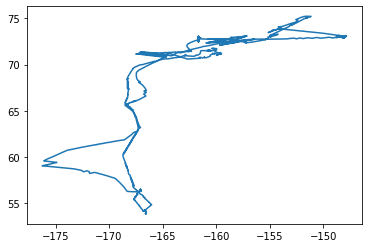

In [10]:
fname = 'F:/data/cruise_data/saildrone/sss/sss_collocations_8day_nearest/saildrone-gen_5-arctic_misst_2019-sd1036-20190514T230000-20191011T183000-1_minutes-v1.1575336154680_JPL8dy.nc'
ds = xr.open_dataset(fname)
plt.plot(ds.lon,ds.lat)